# Next Word Prediction:

### Importing The Required Libraries:

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import pickle
import numpy as np
import os

In [2]:
file = open("../data/praire-clean.txt", "r", encoding = "utf8")
lines = []

for i in file:
    lines.append(i)

### Cleaning the data:

In [3]:
data = ""

for i in lines:
    data = ' '. join(lines)
    
data = data.replace('\n', '').replace('\r', '').replace('\ufeff', '')

In [4]:
import string

translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) #map punctuation to space
new_data = data.translate(translator)

new_data[:500]

'I opened my eyes and saw a pea green world all around me  Then I heard the doctor say   Give  er another whiff or two   His voice sounded far away  as though he were speaking through the Simplon Tunnel  and not merely through his teeth  within twelve inches of my nose   I took my whiff or two  I gulped at that chloroform like a thirsty Bedouin at a wadi spring  I went down into the pea green emptiness again  and forgot about the Kelly pad and the recurring waves of pain that came bigger and bigg'

In [5]:
z = []

for i in data.split():
    if i not in z:
        z.append(i)
        
data = ' '.join(z)
data[:500]

'I opened my eyes and saw a pea-green world all around me. Then heard the doctor say: "Give \'er another whiff or two." His voice sounded far-away, as though he were speaking through Simplon Tunnel, not merely his teeth, within twelve inches of nose. took two. gulped at that chloroform like thirsty Bedouin wadi-spring. went down into emptiness again, forgot about Kelly pad recurring waves pain came bigger tried to sweep racked old body breakers ribs stranded schooner. hateful metallic clink steel '

### Tokenization:

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])

# saving the tokenizer for predict function.
pickle.dump(tokenizer, open('../model/tokenizer_avi.pkl', 'wb'))

sequence_data = tokenizer.texts_to_sequences([data])[0]
sequence_data[:10]

[31, 2618, 403, 404, 1, 657, 24, 2619, 87, 88]

In [7]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

8595


In [8]:
sequences = []

for i in range(1, len(sequence_data)):
    words = sequence_data[i-1:i+1]
    sequences.append(words)

In [9]:
X = []
y = []

for i in sequences:
    X.append(i[0])
    y.append(i[1])
    
X = np.array(X)
y = np.array(y)

In [10]:
print("The Data is: ", X[:5])
print("The responses are: ", y[:5])

The Data is:  [  31 2618  403  404    1]
The responses are:  [2618  403  404    1  657]


In [11]:
y = to_categorical(y, num_classes=vocab_size)

### Creating the Model:

In [37]:
model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=1))
model.add(LSTM(1000, return_sequences=True))
model.add(LSTM(1000))
model.add(Dense(1000, activation="relu"))
model.add(Dense(vocab_size, activation="softmax"))

In [38]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1, 10)             85950     
                                                                 
 lstm_4 (LSTM)               (None, 1, 1000)           4044000   
                                                                 
 lstm_5 (LSTM)               (None, 1000)              8004000   
                                                                 
 dense_4 (Dense)             (None, 1000)              1001000   
                                                                 
 dense_5 (Dense)             (None, 8595)              8603595   
                                                                 
Total params: 21,738,545
Trainable params: 21,738,545
Non-trainable params: 0
_________________________________________________________________


### Callbacks:

In [39]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard

checkpoint = ModelCheckpoint("../model/nextword1.h5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto')

reduce = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=0.0001, verbose = 1)

logdir='logsnextword1'
tensorboard_Visualization = TensorBoard(log_dir=logdir)

### Compile The Model:

In [40]:
import keras.backend as K
def perplexity(y_true, y_pred):
    cross_entropy = K.categorical_crossentropy(y_true, y_pred)
    perplexity = K.pow(2.0, cross_entropy)
    return perplexity

In [41]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.001),metrics=[perplexity,"accuracy"])

### Fit The Model:

In [42]:
history = model.fit(X, y, epochs=150, batch_size=1000, callbacks=[checkpoint, reduce, tensorboard_Visualization])

Epoch 1/150


2022-12-09 04:46:31.827786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-09 04:46:32.214841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-09 04:46:32.261788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-09 04:46:32.501529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-09 04:46:32.591810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - ETA: 0s - loss: 9.0588 - perplexity: 533.3113 - accuracy: 0.0026
Epoch 1: loss improved from inf to 9.05880, saving model to ../model/nextword1.h5
15/15 [==============================] - 5s 197ms/step - loss: 9.0588 - perplexity: 533.3113 - accuracy: 0.0026 - lr: 0.0010
Epoch 2/150
15/15 [==============================] - ETA: 0s - loss: 9.0209 - perplexity: 527.5516 - accuracy: 0.0035
Epoch 2: loss improved from 9.05880 to 9.02090, saving model to ../model/nextword1.h5
15/15 [==============================] - 3s 188ms/step - loss: 9.0209 - perplexity: 527.5516 - accuracy: 0.0035 - lr: 0.0010
Epoch 3/150
15/15 [==============================] - ETA: 0s - loss: 8.8877 - perplexity: 547.2454 - accuracy: 0.0035
Epoch 3: loss improved from 9.02090 to 8.88768, saving model to ../model/nextword1.h5
15/15 [==============================] - 3s 187ms/step - loss: 8.8877 - perplexity: 547.2454 - accuracy: 0.0035 - lr: 0.0010
Epoch 4/150
15/15 [==========

In [44]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'perplexity', 'accuracy', 'lr'])


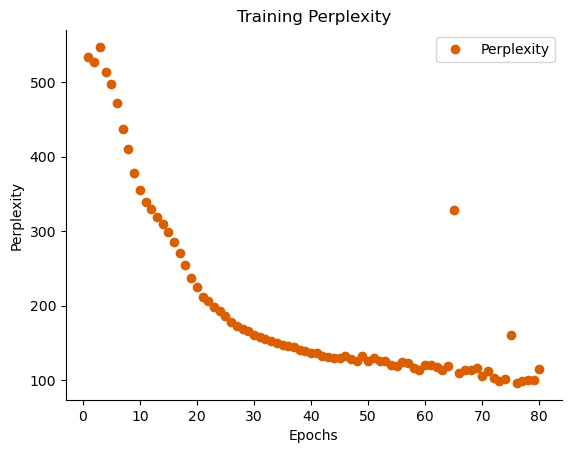

In [51]:
# Plotting training and validation losses
import matplotlib.pyplot as plt
import seaborn as sns
history_dict = history.history
loss_values = history_dict['perplexity'][0:80]
#val_loss_values = history_dict['val_loss']
epochs = range(1, 81)

plt.plot(epochs, loss_values, 'o',c = "#d95f02", label='Perplexity')
#plt.plot(epochs, val_loss_values, '-',c = '#d95f02', label='Validation loss')
plt.title('Training Perplexity')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.legend()
sns.despine()
plt.savefig("../plots/perplexity_lstm_output.png") #save as png
plt.show()

In [53]:
# serialize model to JSON
from tensorflow.keras.models import Sequential, model_from_json
model_json = model.to_json()
with open("../model/nextword.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("../model/nextword_avi.h5")

print("Saved model to disk")

Saved model to disk


### CODE REFERENCE: 
https://www.kaggle.com/code/ysthehurricane/next-word-prediction-bi-lstm-tutorial-easy-way <br>
https://www.analyticsvidhya.com/blog/2021/08/predict-the-next-word-of-your-text-using-long-short-term-memory-lstm/ <br>
https://github.com/Bharath-K3/Next-Word-Prediction-with-NLP-and-Deep-Learning <br>

In [14]:
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.models import load_model
import numpy as np
import pickle

In [15]:
# Load the model and tokenizer
tokenizer = pickle.load(open('../model/tokenizer1.pkl', 'rb'))
# load json and create model
json_file = open('../model/nextword.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("../model/nextword.h5")

2022-12-09 02:55:11.370057: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
